In [334]:
import sys
sys.path.insert(0, '/home/hengji/Documents/hydra_calcium_model/')

from electrical_models.noble_model_add_vgcc2 import ModifiedNobleModelCaL2
from fluorescence_encoder.fluorescence_encoder_smaller_k4n import FluorescenceEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from force_encoder.kato_force_encoder import KatoForceEncoder

T= 100
dt = 0.001

In [395]:
class SingleCellCalciumModelTwoPart(ModifiedNobleModelCaL2):
    def __init__(self):
        super().__init__()
        self.ct0 = 35
        self.hh0 = None
        self.ip0 = 0.01
        self.gamma = 5.4054
        self.delta = 0.2
        self.v_ip3r = 1.3 # 1.5
        self.d_1 = 0.01
        self.d_2 = 8
        self.d_3 = 0.9434
        self.d_4 = 0.13
        self.d_5 = 0.08234
        self.a_2 =  3.0
        self.ip_decay = 0.2
        self.time = np.linspace(0, T, int(T/dt))
    
    # Calcium terms
    def i_ip3r(self, c, c_t, hh, ip):
        mm_inf = ip/(ip + self.d_1)
        nn_inf = c/(c + self.d_5)
        
#         nn_inf0 = self.c0/(self.c0 + self.d_5)     
#         ((nn_inf0**3 * self.hh0**3) if ip > (self.ip0+0.001) else (nn_inf**3 * hh**3))) * \

        return self.v_ip3r * (0.05 * mm_inf ** 3 + 0.5 ** 3 * (nn_inf**3 * hh**3 * (2 * self.ip0 / (ip + self.ip0)) **3 )) * \
            ((c_t-c)*self.gamma - c)
    
    def i_serca(self, c):
        v_serca = 14 # 14.5
        k_serca = 0.1
        return v_serca * c / (c + k_serca)
    
    def i_leak(self, c, c_t):
        v_leak = (- self.i_ip3r(self.c0, self.ct0, self.hh0, self.ip0) \
                  + self.i_serca(self.c0)) \
                  / ((self.ct0-self.c0)*self.gamma - self.c0)
        
        return v_leak * ((c_t-c)*self.gamma - c)
    
    def i_pmca(self, c):
        k_pmca =  1.5 
        v_pmca = 5 # 12
        
        return v_pmca * c**2 / (k_pmca**2 + c**2)
    
    def i_soc(self, c, c_t):
        
        v_soc = 0
        k_soc = 0
        
        return v_soc * k_soc**4 / (k_soc**4 + ((c_t-c)*self.gamma)**4)
    
    def i_out(self, c):
        k_out = (- self.i_cal(self.v0, self.m_cal0, self.h_cal0) - self.i_pmca(self.c0) + self.i_soc(self.c0, self.ct0)) \
        / self.c0
        return k_out*c
    
    def hh_inf(self, c, ip):
#         q_2 = self.d_2 * (ip + self.d_4)/(ip + self.d_3)
        q_2 = self.d_2 * (self.ip0 + self.d_4)/(self.ip0 + self.d_3)
        return q_2 / (q_2 + c)
    
    def tau_hh(self, c, ip):
        q_2 = self.d_2 * (self.ip0 + self.d_4)/(self.ip0 + self.d_3)
        return 1 / (self.a_2 * (q_2 + c))
    
    # Override
    def stim_ip3(self, t):
        
        if t >= 1 and t < 6 or t >= 7 and t < 12 or t >= 13 and t < 18 or 19 <= t < 24: # or 25 <= t < 30 or 31 <= t < 36:
            return 1
        else:
            return 0
        
    def stim_v(self, t):

        if t >= 55 and t < 55.1 or t >= 57 and t < 57.1 or t >= 59 and t < 59.1 or t >= 61 and t < 61.1 or t >= 63 and t < 63.1 or t >= 65 and t < 65.1:
            return 1
        else:
            return 0
    
    def rhs(self, y, t):
        c, c_t, hh, ip, v, m, h, n, m_cal, h_cal = y
    
        dcdt = (self.i_ip3r(c, c_t, hh, ip) \
             - self.i_serca(c) \
             + self.i_leak(c, c_t)) \
             + (- self.i_pmca(c) \
                - self.i_cal(v, m_cal, h_cal) \
                + self.i_soc(c, c_t) \
                - self.i_out(c)) * self.delta
        
        dctdt = (- self.i_pmca(c) \
                       - self.i_cal(v, m_cal, h_cal) \
                       + self.i_soc(c, c_t) \
                       - self.i_out(c))\
                 * self.delta

        dhhdt = (self.hh_inf(c, ip) - hh) / self.tau_hh(c, ip)

        dipdt = 0.02 * self.stim_ip3(t) - self.ip_decay * (ip - self.ip0)
        
#         dipdt = 0

        dvdt = - (self.i_na(v,m,h) \
                  + self.i_k(v,n) \
                  + self.i_bk(v) \
#                   + 2*self.i_cal(v, m_cal, h_cal))/self.c_m  
                  + 2*self.i_cal(v, m_cal, h_cal) \
                  - self.stim_v(t))/self.c_m  
        
        dmdt = self.alpha_m(v) * (1-m) - self.beta_m(v) * m
        dhdt = self.alpha_h(v) * (1-h) - self.beta_h(v) * h
        dndt = self.alpha_n(v) * (1-n) - self.beta_n(v) * n
        dmcaldt = (self.m_cal_inf(v) - m_cal) / self.tau_cal_m(v)
        dhcaldt = (self.h_cal_inf(v) - h_cal) / self.tau_cal_h(v)
        
        return [dcdt, dctdt, dhhdt, dipdt, dvdt, dmdt, dhdt, dndt, dmcaldt, dhcaldt]
    
    # Override
    def step(self):
        self.hh0 = self.hh_inf(self.c0, self.ip0)
        
        y0 = [self.c0, self.ct0, self.hh0, self.ip0,
              self.v0, self.m0, self.h0, self.n0, self.m_cal0, self.h_cal0]
        sol = odeint(self.rhs, y0, self.time, hmax = 0.005)
        return sol
    
    
    # Plot
    def plot(self, a, tmin=0, tmax=-1):
        
        plt.figure(figsize=(7,4))
        plt.plot(self.time[int(tmin/dt):int(tmax/dt)], a[int(tmin/dt):int(tmax/dt)])
        plt.show()

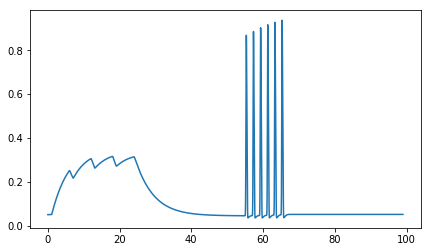

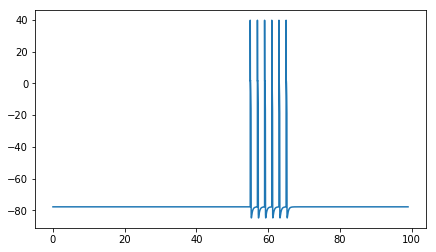

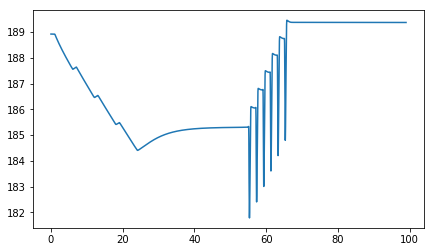

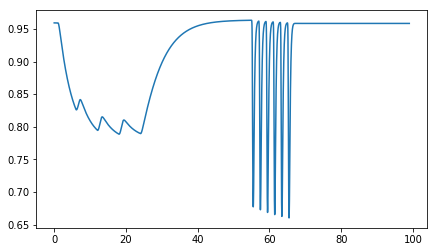

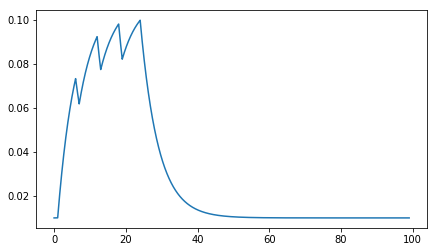

In [396]:
if __name__ == '__main__':
    aa = SingleCellCalciumModelTwoPart()
    sol = aa.step()
    c = sol[:,0]
    c_t = sol[:,1]
    hh = sol[:,2]
    ip = sol[:,3]
    v = sol[:,4]
    m = sol[:,5]
    h = sol[:,6]
    
    n = sol[:,7]
    m_cal = sol[:,8]
    h_cal = sol[:,9]
    aa.plot(c)
    aa.plot(v)
    aa.plot((c_t - c)*aa.gamma)
    aa.plot(hh)
    aa.plot(ip)

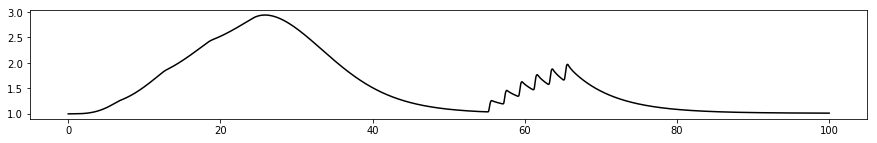

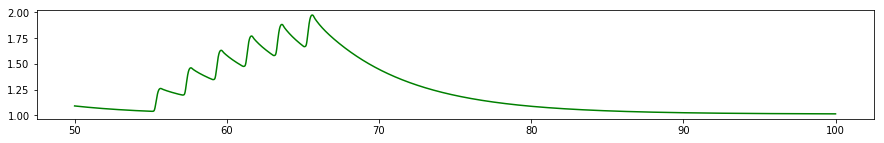

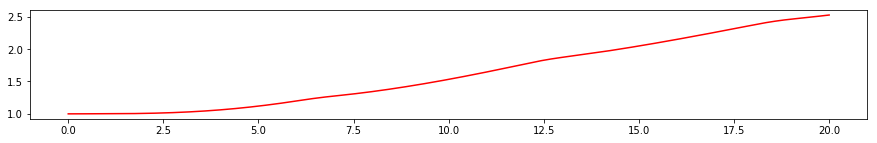

In [397]:
time = aa.time
fluo = FluorescenceEncoder(c, T, dt).step()

plt.figure(figsize = (15,2))
plt.plot(time[:], fluo[:], 'k-')
plt.show()
plt.figure(figsize = (15,2))
plt.plot(time[50000:], fluo[50000:], 'g-')
plt.show()
plt.figure(figsize = (15,2))
plt.plot(time[:20000], fluo[:20000], 'r-')
plt.show()